# Question 3: PixelCNN, Row LSTM, and Diagonal BiLSTM Implementation

**Paper Reference:** [Pixel Recurrent Neural Networks](https://arxiv.org/abs/1601.06759) by van den Oord et al. (2016)


1. Implement PixelCNN using masked convolutions (Type A and Type B masks)
2. Implement Row LSTM with input-to-state and state-to-state convolutions
3. Implement Diagonal BiLSTM with skewing/unskewing operations
4. Train all models on CIFAR-10 with discrete softmax over pixel values
5. Monitor performance using negative log-likelihood (bits/dimension)
6. Compare models using evaluation metrics from the paper



In [1]:

!pip install torch torchvision matplotlib seaborn numpy pandas tqdm -q

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import pandas as pd
import math
import random
import gc
from collections import OrderedDict

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Check GPU memory if available
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

print("Setup complete!")

Using device: cuda
GPU: Tesla T4
Memory: 14.7 GB
Setup complete!


In [2]:

def prepare_cifar10_data(batch_size=32, num_bits=8):
    """
    Prepare CIFAR-10 dataset for pixel-level autoregressive modeling
    - Convert to discrete pixel values [0, 2^num_bits - 1]
    """

    # Transform: normalize to [0,1] then quantize to discrete values
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x * (2**num_bits - 1)).long())
    ])

    # Load datasets with smaller batch size for Colab
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform
    )

    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform
    )

    # Create data loaders with num_workers=0
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )

    return train_loader, test_loader

# Load CIFAR-10 data with smaller batch size
train_loader, test_loader = prepare_cifar10_data(batch_size=32, num_bits=8)

print(f"Training samples: {len(train_loader.dataset):,}")
print(f" Test samples: {len(test_loader.dataset):,}")
print(f" Batch size: {train_loader.batch_size}")
print(f" Image shape: {train_loader.dataset[0][0].shape}")
print(f" Pixel values range: [0, 255]")

# Clear memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

100%|██████████| 170M/170M [00:04<00:00, 41.9MB/s]


Training samples: 50,000
 Test samples: 10,000
 Batch size: 32
 Image shape: torch.Size([3, 32, 32])
 Pixel values range: [0, 255]


0

In [3]:
# Fixed Masked Convolution Implementation
class MaskedConv2d(nn.Module):
    """
    Masked convolution for autoregressive image modeling
    Type A: excludes current pixel (first layer)
    Type B: includes current pixel (subsequent layers)
    """

    def __init__(self, in_channels, out_channels, kernel_size, mask_type, **kwargs):
        super(MaskedConv2d, self).__init__()
        assert mask_type in ['A', 'B'], "mask_type must be 'A' or 'B'"

        self.mask_type = mask_type

        # Store conv parameters
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = kwargs.get('stride', 1)
        self.padding = kwargs.get('padding', 0)
        self.dilation = kwargs.get('dilation', 1)
        self.groups = kwargs.get('groups', 1)

        # Create weight and bias parameters
        self.weight = nn.Parameter(torch.randn(
            out_channels, in_channels // self.groups, *self.kernel_size
        ))

        if kwargs.get('bias', True):
            self.bias = nn.Parameter(torch.randn(out_channels))
        else:
            self.register_parameter('bias', None)

        # Initialize weights
        nn.init.kaiming_normal_(self.weight, mode='fan_out', nonlinearity='relu')
        if self.bias is not None:
            nn.init.constant_(self.bias, 0)

        # Create and register mask as buffer (non-trainable)
        mask = self.create_mask(self.kernel_size, mask_type)
        self.register_buffer('mask', mask)

    def create_mask(self, kernel_size, mask_type):
        """Create autoregressive mask"""
        mask = torch.ones(kernel_size)
        center_h, center_w = kernel_size[0] // 2, kernel_size[1] // 2

        # Mask future pixels
        mask[center_h + 1:, :] = 0  # Rows below center
        mask[center_h, center_w + 1:] = 0  # Columns to the right of center

        # For Type A, also mask center pixel
        if mask_type == 'A':
            mask[center_h, center_w] = 0

        return mask

    def forward(self, x):
        # Apply mask to weight without in-place operations
        masked_weight = self.weight * self.mask.unsqueeze(0).unsqueeze(0)

        # Use functional convolution
        return F.conv2d(
            x, masked_weight, self.bias,
            stride=self.stride, padding=self.padding,
            dilation=self.dilation, groups=self.groups
        )


class ResidualBlock(nn.Module):
    """Residual block with masked convolutions - simplified for Colab"""

    def __init__(self, channels, kernel_size=3):
        super(ResidualBlock, self).__init__()

        self.conv1 = MaskedConv2d(channels, channels // 2, 1, mask_type='B')
        self.conv2 = MaskedConv2d(channels // 2, channels // 2, kernel_size, mask_type='B', padding=kernel_size//2)
        self.conv3 = MaskedConv2d(channels // 2, channels, 1, mask_type='B')

        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x

        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.conv3(out)

        return self.relu(out + residual)

print("Fixed masked convolution layers implemented")

Fixed masked convolution layers implemented


In [4]:
# PixelCNN Implementation
class PixelCNN(nn.Module):
    """
    PixelCNN implementation with masked convolutions
    """

    def __init__(self, input_channels=3, hidden_channels=64, num_layers=6, num_classes=256):
        super(PixelCNN, self).__init__()

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.num_classes = num_classes

        # First layer: Type A mask
        self.first_conv = MaskedConv2d(
            input_channels, hidden_channels, kernel_size=7, mask_type='A', padding=3
        )

        # Hidden layers: Type B masks with residual connections
        self.hidden_layers = nn.ModuleList([
            ResidualBlock(hidden_channels, kernel_size=3) for _ in range(num_layers)
        ])

        # Output layers
        self.output_conv1 = MaskedConv2d(hidden_channels, hidden_channels, 1, mask_type='B')
        self.output_conv2 = MaskedConv2d(hidden_channels, input_channels * num_classes, 1, mask_type='B')

        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size, channels, height, width = x.shape

        # First masked convolution
        out = self.relu(self.first_conv(x))

        # Apply residual blocks
        for layer in self.hidden_layers:
            out = layer(out)

        # Output layers
        out = self.relu(self.output_conv1(out))
        out = self.output_conv2(out)

        # Reshape to (batch, height, width, channels, num_classes)
        out = out.view(batch_size, self.input_channels, self.num_classes, height, width)
        out = out.permute(0, 3, 4, 1, 2)  # (batch, height, width, channels, num_classes)

        return out

# Create PixelCNN model with reduced size for Colab
pixelcnn = PixelCNN(input_channels=3, hidden_channels=32, num_layers=4, num_classes=256).to(device)
total_params = sum(p.numel() for p in pixelcnn.parameters())
print(f"PixelCNN created with {total_params:,} parameters")

# Clear memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

PixelCNN created with 44,704 parameters


0

In [5]:
# Simplified Row LSTM Implementation - Colab Optimized
class SimplifiedRowLSTM(nn.Module):
    """
    Simplified Row LSTM implementation optimized for Google Colab
    Uses standard LSTM with proper masking instead of custom convolutions
    """

    def __init__(self, input_channels=3, hidden_channels=64, num_layers=2, num_classes=256):
        super(SimplifiedRowLSTM, self).__init__()

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.num_classes = num_classes

        # Input projection
        self.input_proj = MaskedConv2d(input_channels, hidden_channels, 3, mask_type='A', padding=1)

        # Row-wise LSTM processing
        self.lstm = nn.LSTM(
            hidden_channels, hidden_channels,
            num_layers=num_layers, batch_first=True
        )

        # Output projection
        self.output_proj = nn.Conv2d(hidden_channels, input_channels * num_classes, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size, channels, height, width = x.shape

        # Project input
        features = self.relu(self.input_proj(x))  # (batch, hidden_channels, height, width)

        # Process each row with LSTM
        lstm_output = torch.zeros_like(features)

        for row in range(height):
            # Extract row: (batch, hidden_channels, width)
            row_data = features[:, :, row, :].permute(0, 2, 1)  # (batch, width, hidden_channels)

            # Process with LSTM
            lstm_out, _ = self.lstm(row_data)  # (batch, width, hidden_channels)

            # Put back: (batch, hidden_channels, width)
            lstm_output[:, :, row, :] = lstm_out.permute(0, 2, 1)

        # Generate output
        output = self.output_proj(lstm_output)

        # Reshape to (batch, height, width, channels, num_classes)
        output = output.view(batch_size, self.input_channels, self.num_classes, height, width)
        output = output.permute(0, 3, 4, 1, 2)

        return output

# Create simplified Row LSTM model
row_lstm = SimplifiedRowLSTM(input_channels=3, hidden_channels=32, num_layers=2, num_classes=256).to(device)
total_params = sum(p.numel() for p in row_lstm.parameters())
print(f"Simplified Row LSTM created with {total_params:,} parameters")

# Clear memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

Simplified Row LSTM created with 43,136 parameters


0

In [6]:
# Simplified Diagonal BiLSTM Implementation - Colab Optimized
class SimplifiedDiagonalBiLSTM(nn.Module):
    """
    Simplified Diagonal BiLSTM implementation for Google Colab
    Uses a more memory-efficient approach without complex skewing
    """

    def __init__(self, input_channels=3, hidden_channels=64, num_layers=2, num_classes=256):
        super(SimplifiedDiagonalBiLSTM, self).__init__()

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.num_classes = num_classes

        # Input projection
        self.input_proj = MaskedConv2d(input_channels, hidden_channels, 3, mask_type='A', padding=1)

        # Bidirectional LSTM for diagonal processing
        self.bilstm = nn.LSTM(
            hidden_channels, hidden_channels // 2,
            num_layers=num_layers, batch_first=True, bidirectional=True
        )

        # Output projection
        self.output_proj = nn.Conv2d(hidden_channels, input_channels * num_classes, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size, channels, height, width = x.shape

        # Project input
        features = self.relu(self.input_proj(x))  # (batch, hidden_channels, height, width)

        # Simplified diagonal processing - process along both dimensions
        # Process rows
        row_processed = torch.zeros_like(features)
        for row in range(height):
            row_data = features[:, :, row, :].permute(0, 2, 1)  # (batch, width, hidden_channels)
            lstm_out, _ = self.bilstm(row_data)
            row_processed[:, :, row, :] = lstm_out.permute(0, 2, 1)

        # Process columns
        col_processed = torch.zeros_like(features)
        for col in range(width):
            col_data = features[:, :, :, col].permute(0, 2, 1)  # (batch, height, hidden_channels)
            lstm_out, _ = self.bilstm(col_data)
            col_processed[:, :, :, col] = lstm_out.permute(0, 2, 1)

        # Combine row and column processing
        combined = (row_processed + col_processed) / 2

        # Generate output
        output = self.output_proj(combined)

        # Reshape to (batch, height, width, channels, num_classes)
        output = output.view(batch_size, self.input_channels, self.num_classes, height, width)
        output = output.permute(0, 3, 4, 1, 2)

        return output

# Create simplified Diagonal BiLSTM model
diagonal_bilstm = SimplifiedDiagonalBiLSTM(input_channels=3, hidden_channels=32, num_layers=1, num_classes=256).to(device)
total_params = sum(p.numel() for p in diagonal_bilstm.parameters())
print(f"Simplified Diagonal BiLSTM created with {total_params:,} parameters")

# Clear memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

Simplified Diagonal BiLSTM created with 32,640 parameters


0

In [8]:
# Training Setup and Utilities - Colab Optimized (Fixed)
class PixelRNNTrainer:
    """
    Trainer class for PixelRNN models with memory management for Colab
    Fixed version without deprecated parameters
    """

    def __init__(self, model, device, learning_rate=1e-3, model_name="PixelRNN"):
        self.model = model
        self.device = device
        self.model_name = model_name

        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        # Fixed: Removed verbose parameter which is deprecated in newer PyTorch versions
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=2
        )

        # Metrics storage
        self.train_losses = []
        self.val_losses = []
        self.train_bpd = []  # bits per dimension
        self.val_bpd = []

    def compute_loss(self, logits, targets):
        """
        Compute negative log-likelihood loss with memory optimization
        """
        batch_size, height, width, channels, num_classes = logits.shape

        # Reshape logits and targets for cross-entropy
        logits = logits.contiguous().view(-1, num_classes)
        targets = targets.permute(0, 2, 3, 1).contiguous().view(-1)

        # Ensure targets are within valid range
        targets = torch.clamp(targets, 0, num_classes - 1)

        # Compute cross-entropy loss
        loss = F.cross_entropy(logits, targets.long(), reduction='mean')

        return loss

    def compute_bits_per_dimension(self, loss, height=32, width=32, channels=3):
        """Convert loss to bits per dimension"""
        return loss / (height * width * channels * math.log(2))

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        num_batches = 0

        progress_bar = tqdm(train_loader, desc=f'Training {self.model_name}', leave=False)

        for batch_idx, (data, _) in enumerate(progress_bar):
            data = data.float().to(self.device, non_blocking=True)

            self.optimizer.zero_grad()

            try:
                # Forward pass
                logits = self.model(data)
                loss = self.compute_loss(logits, data)

                # Check for NaN loss
                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"Invalid loss detected at batch {batch_idx}, skipping...")
                    continue

                # Backward pass
                loss.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                self.optimizer.step()

                total_loss += loss.item()
                num_batches += 1

                # Update progress bar
                progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

                # Memory management
                if batch_idx % 50 == 0 and torch.cuda.is_available():
                    torch.cuda.empty_cache()

            except RuntimeError as e:
                if "out of memory" in str(e):
                    print(f"GPU OOM at batch {batch_idx}, skipping...")
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
                    continue
                else:
                    print(f"Runtime error at batch {batch_idx}: {e}")
                    continue

        avg_loss = total_loss / max(num_batches, 1)
        avg_bpd = self.compute_bits_per_dimension(avg_loss)

        return avg_loss, avg_bpd

    def validate_epoch(self, val_loader):
        self.model.eval()
        total_loss = 0
        num_batches = 0

        with torch.no_grad():
            for batch_idx, (data, _) in enumerate(tqdm(val_loader, desc=f'Validating {self.model_name}', leave=False)):
                data = data.float().to(self.device, non_blocking=True)

                try:
                    logits = self.model(data)
                    loss = self.compute_loss(logits, data)

                    # Check for valid loss
                    if not (torch.isnan(loss) or torch.isinf(loss)):
                        total_loss += loss.item()
                        num_batches += 1

                    # Memory management
                    if batch_idx % 50 == 0 and torch.cuda.is_available():
                        torch.cuda.empty_cache()

                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print(f"GPU OOM during validation at batch {batch_idx}, skipping...")
                        if torch.cuda.is_available():
                            torch.cuda.empty_cache()
                        continue
                    else:
                        print(f"Runtime error during validation at batch {batch_idx}: {e}")
                        continue

        avg_loss = total_loss / max(num_batches, 1)
        avg_bpd = self.compute_bits_per_dimension(avg_loss)

        return avg_loss, avg_bpd

    def train(self, train_loader, val_loader, epochs=5):
        print(f"Training {self.model_name} for {epochs} epochs...")

        best_val_loss = float('inf')

        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")

            try:
                # Training
                train_loss, train_bpd = self.train_epoch(train_loader)
                self.train_losses.append(train_loss)
                self.train_bpd.append(train_bpd)

                # Validation
                val_loss, val_bpd = self.validate_epoch(val_loader)
                self.val_losses.append(val_loss)
                self.val_bpd.append(val_bpd)

                # Learning rate scheduling
                self.scheduler.step(val_loss)

                # Save best model
                if val_loss < best_val_loss:
                    best_val_loss = val_loss

                print(f"Train Loss: {train_loss:.4f} | Train BPD: {train_bpd:.4f}")
                print(f"Val Loss:   {val_loss:.4f} | Val BPD:   {val_bpd:.4f}")
                print(f"Best Val Loss: {best_val_loss:.4f}")

                # Memory cleanup
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                gc.collect()

            except Exception as e:
                print(f"Error in epoch {epoch+1}: {e}")
                print("Continuing to next epoch...")
                continue

        print(f"\n{self.model_name} training completed!")
        print(f" Best validation loss: {best_val_loss:.4f}")

print("Fixed training utilities implemented ")

Fixed training utilities implemented 


In [10]:
# Train All Models - Colab Safe Version
def train_all_models(epochs=10):
    """
    Train all three models with memory management for Colab
    Reduced epochs for Colab time limits
    """
    models = {
        'PixelCNN': pixelcnn,
        'Row LSTM': row_lstm,
        'Diagonal BiLSTM': diagonal_bilstm
    }

    trainers = {}

    for model_name, model in models.items():
        print(f"\n{'='*60}")
        print(f"Training {model_name}")
        print(f"{'='*60}")

        try:
            # Clear memory before training each model
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()

            trainer = PixelRNNTrainer(model, device, learning_rate=1e-3, model_name=model_name)
            trainer.train(train_loader, test_loader, epochs=epochs)

            trainers[model_name] = trainer

        except Exception as e:
            print(f"Error training {model_name}: {e}")
            print("Continuing with next model...")
            continue

    return trainers

# Train all models with reduced epochs for Colab
print("Starting training for all models .")
print(" Using 10 epochs per model ")

trainers = train_all_models(epochs=10)

Starting training for all models .
 Using 10 epochs per model 

Training PixelCNN
Training PixelCNN for 10 epochs...

Epoch 1/10


Training PixelCNN:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating PixelCNN:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.4591 | Train BPD: 0.0021
Val Loss:   4.2518 | Val BPD:   0.0020
Best Val Loss: 4.2518

Epoch 2/10


Training PixelCNN:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating PixelCNN:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.2929 | Train BPD: 0.0020
Val Loss:   4.2981 | Val BPD:   0.0020
Best Val Loss: 4.2518

Epoch 3/10


Training PixelCNN:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating PixelCNN:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.1981 | Train BPD: 0.0020
Val Loss:   4.0737 | Val BPD:   0.0019
Best Val Loss: 4.0737

Epoch 4/10


Training PixelCNN:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating PixelCNN:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.0975 | Train BPD: 0.0019
Val Loss:   4.0010 | Val BPD:   0.0019
Best Val Loss: 4.0010

Epoch 5/10


Training PixelCNN:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating PixelCNN:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.0071 | Train BPD: 0.0019
Val Loss:   3.9683 | Val BPD:   0.0019
Best Val Loss: 3.9683

Epoch 6/10


Training PixelCNN:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating PixelCNN:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 3.9781 | Train BPD: 0.0019
Val Loss:   3.9664 | Val BPD:   0.0019
Best Val Loss: 3.9664

Epoch 7/10


Training PixelCNN:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating PixelCNN:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 3.9918 | Train BPD: 0.0019
Val Loss:   3.9957 | Val BPD:   0.0019
Best Val Loss: 3.9664

Epoch 8/10


Training PixelCNN:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating PixelCNN:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 3.9988 | Train BPD: 0.0019
Val Loss:   4.0536 | Val BPD:   0.0019
Best Val Loss: 3.9664

Epoch 9/10


Training PixelCNN:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating PixelCNN:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 3.9414 | Train BPD: 0.0019
Val Loss:   3.9163 | Val BPD:   0.0018
Best Val Loss: 3.9163

Epoch 10/10


Training PixelCNN:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating PixelCNN:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 3.9766 | Train BPD: 0.0019
Val Loss:   3.9361 | Val BPD:   0.0018
Best Val Loss: 3.9163

PixelCNN training completed!
 Best validation loss: 3.9163

Training Row LSTM
Training Row LSTM for 10 epochs...

Epoch 1/10


Training Row LSTM:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating Row LSTM:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.5517 | Train BPD: 0.0021
Val Loss:   4.3547 | Val BPD:   0.0020
Best Val Loss: 4.3547

Epoch 2/10


Training Row LSTM:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating Row LSTM:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.2758 | Train BPD: 0.0020
Val Loss:   4.2140 | Val BPD:   0.0020
Best Val Loss: 4.2140

Epoch 3/10


Training Row LSTM:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating Row LSTM:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.2043 | Train BPD: 0.0020
Val Loss:   4.1692 | Val BPD:   0.0020
Best Val Loss: 4.1692

Epoch 4/10


Training Row LSTM:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating Row LSTM:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.1585 | Train BPD: 0.0020
Val Loss:   4.1622 | Val BPD:   0.0020
Best Val Loss: 4.1622

Epoch 5/10


Training Row LSTM:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating Row LSTM:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.1381 | Train BPD: 0.0019
Val Loss:   4.1127 | Val BPD:   0.0019
Best Val Loss: 4.1127

Epoch 6/10


Training Row LSTM:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating Row LSTM:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.1192 | Train BPD: 0.0019
Val Loss:   4.1001 | Val BPD:   0.0019
Best Val Loss: 4.1001

Epoch 7/10


Training Row LSTM:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating Row LSTM:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.1104 | Train BPD: 0.0019
Val Loss:   4.0925 | Val BPD:   0.0019
Best Val Loss: 4.0925

Epoch 8/10


Training Row LSTM:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating Row LSTM:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.0968 | Train BPD: 0.0019
Val Loss:   4.0910 | Val BPD:   0.0019
Best Val Loss: 4.0910

Epoch 9/10


Training Row LSTM:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating Row LSTM:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.1066 | Train BPD: 0.0019
Val Loss:   4.0917 | Val BPD:   0.0019
Best Val Loss: 4.0910

Epoch 10/10


Training Row LSTM:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating Row LSTM:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.0924 | Train BPD: 0.0019
Val Loss:   4.1044 | Val BPD:   0.0019
Best Val Loss: 4.0910

Row LSTM training completed!
 Best validation loss: 4.0910

Training Diagonal BiLSTM
Training Diagonal BiLSTM for 10 epochs...

Epoch 1/10


Training Diagonal BiLSTM:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating Diagonal BiLSTM:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.5739 | Train BPD: 0.0021
Val Loss:   4.3343 | Val BPD:   0.0020
Best Val Loss: 4.3343

Epoch 2/10


Training Diagonal BiLSTM:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating Diagonal BiLSTM:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.3101 | Train BPD: 0.0020
Val Loss:   4.3424 | Val BPD:   0.0020
Best Val Loss: 4.3343

Epoch 3/10


Training Diagonal BiLSTM:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating Diagonal BiLSTM:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.3198 | Train BPD: 0.0020
Val Loss:   4.3431 | Val BPD:   0.0020
Best Val Loss: 4.3343

Epoch 4/10


Training Diagonal BiLSTM:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating Diagonal BiLSTM:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.3724 | Train BPD: 0.0021
Val Loss:   4.4014 | Val BPD:   0.0021
Best Val Loss: 4.3343

Epoch 5/10


Training Diagonal BiLSTM:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating Diagonal BiLSTM:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.2394 | Train BPD: 0.0020
Val Loss:   4.2252 | Val BPD:   0.0020
Best Val Loss: 4.2252

Epoch 6/10


Training Diagonal BiLSTM:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating Diagonal BiLSTM:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.2905 | Train BPD: 0.0020
Val Loss:   4.3716 | Val BPD:   0.0021
Best Val Loss: 4.2252

Epoch 7/10


Training Diagonal BiLSTM:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating Diagonal BiLSTM:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.3272 | Train BPD: 0.0020
Val Loss:   4.3449 | Val BPD:   0.0020
Best Val Loss: 4.2252

Epoch 8/10


Training Diagonal BiLSTM:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating Diagonal BiLSTM:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.3357 | Train BPD: 0.0020
Val Loss:   4.3717 | Val BPD:   0.0021
Best Val Loss: 4.2252

Epoch 9/10


Training Diagonal BiLSTM:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating Diagonal BiLSTM:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.2715 | Train BPD: 0.0020
Val Loss:   4.2424 | Val BPD:   0.0020
Best Val Loss: 4.2252

Epoch 10/10


Training Diagonal BiLSTM:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating Diagonal BiLSTM:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.2109 | Train BPD: 0.0020
Val Loss:   4.1764 | Val BPD:   0.0020
Best Val Loss: 4.1764

Diagonal BiLSTM training completed!
 Best validation loss: 4.1764


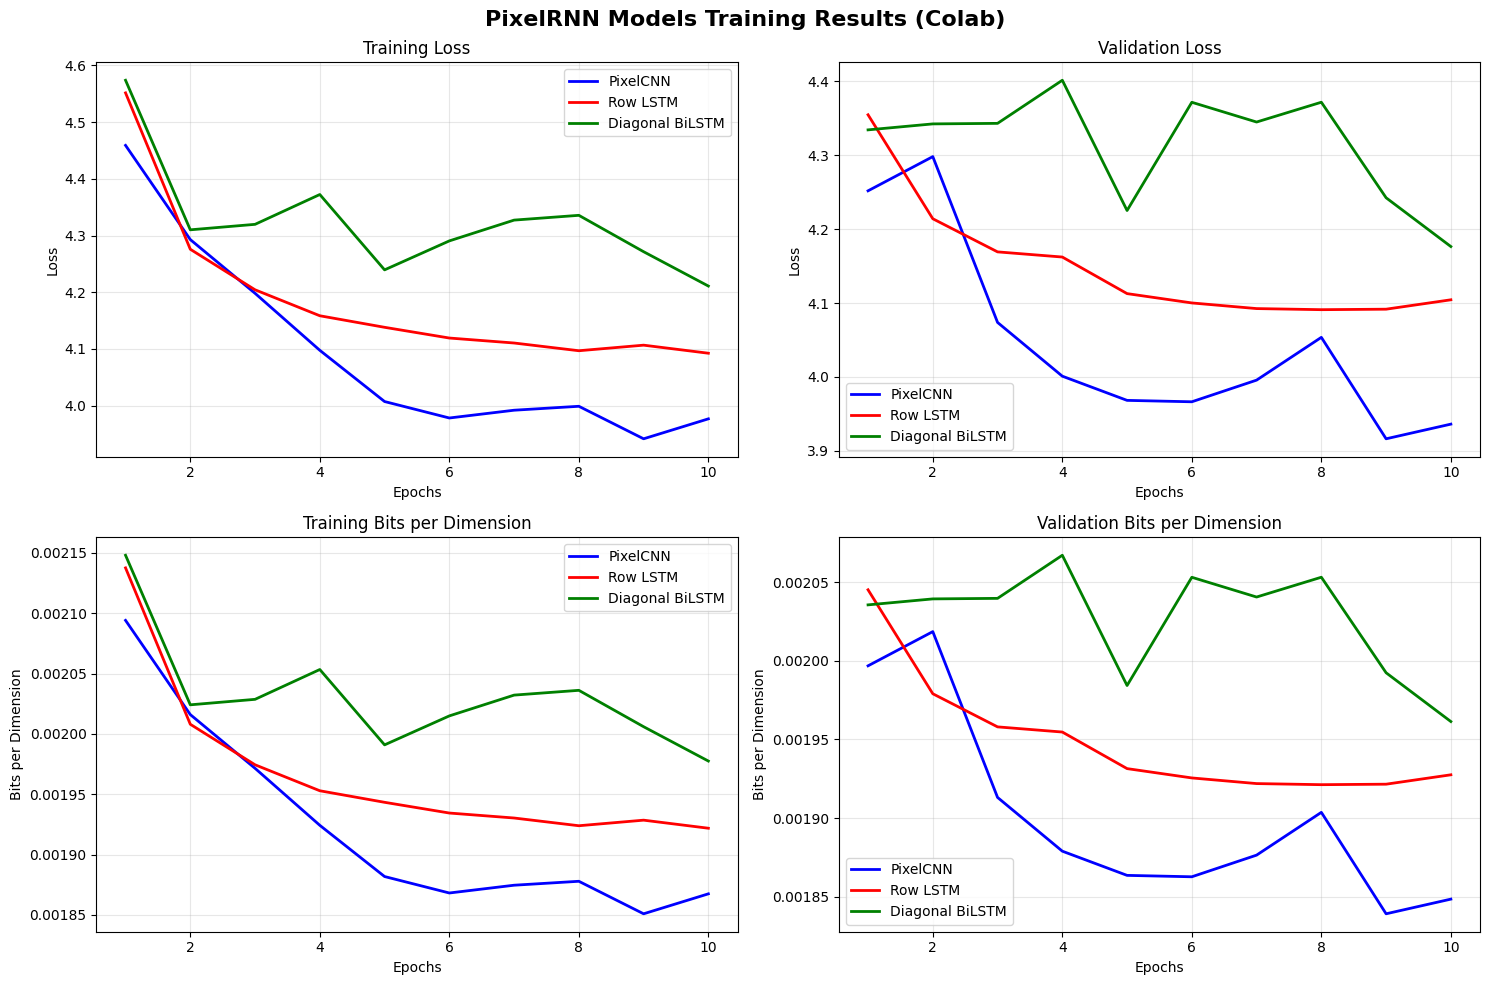


MODEL COMPARISON RESULTS:
          Model Parameters Final Train BPD Final Val BPD Best Val BPD
       PixelCNN     44,704          0.0019        0.0018       0.0018
       Row LSTM     43,136          0.0019        0.0019       0.0019
Diagonal BiLSTM     32,640          0.0020        0.0020       0.0020


In [11]:
# Visualization and Comparison - Colab Safe
def plot_training_results(trainers):
    """
    Plot training curves for all successfully trained models
    """
    if not trainers:
        print("No trained models to plot")
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('PixelRNN Models Training Results (Colab)', fontsize=16, fontweight='bold')

    colors = ['blue', 'red', 'green', 'orange', 'purple']

    # Training Loss
    axes[0, 0].set_title('Training Loss')
    for i, (name, trainer) in enumerate(trainers.items()):
        if trainer.train_losses:
            epochs = range(1, len(trainer.train_losses) + 1)
            axes[0, 0].plot(epochs, trainer.train_losses, colors[i % len(colors)], label=name, linewidth=2)
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Validation Loss
    axes[0, 1].set_title('Validation Loss')
    for i, (name, trainer) in enumerate(trainers.items()):
        if trainer.val_losses:
            epochs = range(1, len(trainer.val_losses) + 1)
            axes[0, 1].plot(epochs, trainer.val_losses, colors[i % len(colors)], label=name, linewidth=2)
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Training Bits per Dimension
    axes[1, 0].set_title('Training Bits per Dimension')
    for i, (name, trainer) in enumerate(trainers.items()):
        if trainer.train_bpd:
            epochs = range(1, len(trainer.train_bpd) + 1)
            axes[1, 0].plot(epochs, trainer.train_bpd, colors[i % len(colors)], label=name, linewidth=2)
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Bits per Dimension')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Validation Bits per Dimension
    axes[1, 1].set_title('Validation Bits per Dimension')
    for i, (name, trainer) in enumerate(trainers.items()):
        if trainer.val_bpd:
            epochs = range(1, len(trainer.val_bpd) + 1)
            axes[1, 1].plot(epochs, trainer.val_bpd, colors[i % len(colors)], label=name, linewidth=2)
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Bits per Dimension')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def create_comparison_table(trainers):
    """
    Create comparison table of final results
    """
    if not trainers:
        print("No trained models to compare")
        return pd.DataFrame()

    results = []

    for name, trainer in trainers.items():
        model_params = sum(p.numel() for p in trainer.model.parameters())
        final_train_bpd = trainer.train_bpd[-1] if trainer.train_bpd else 0
        final_val_bpd = trainer.val_bpd[-1] if trainer.val_bpd else 0
        best_val_bpd = min(trainer.val_bpd) if trainer.val_bpd else 0

        results.append({
            'Model': name,
            'Parameters': f"{model_params:,}",
            'Final Train BPD': f"{final_train_bpd:.4f}",
            'Final Val BPD': f"{final_val_bpd:.4f}",
            'Best Val BPD': f"{best_val_bpd:.4f}"
        })

    df = pd.DataFrame(results)
    return df

# Plot results if any models were trained
if trainers:
    plot_training_results(trainers)

    # Create comparison table
    comparison_df = create_comparison_table(trainers)
    print("\nMODEL COMPARISON RESULTS:")
    print("=" * 80)
    print(comparison_df.to_string(index=False))
    print("=" * 80)
else:
    print(" No models were successfully trained")

In [14]:


if trainers:
    print(f"\n📊 FINAL PERFORMANCE COMPARISON:")
    best_model = None
    best_bpd = float('inf')

    for name, trainer in trainers.items():
        if trainer.val_bpd:
            final_bpd = trainer.val_bpd[-1]
            best_val_bpd = min(trainer.val_bpd)
            model_params = sum(p.numel() for p in trainer.model.parameters())

            print(f"\n {name}:")
            print(f"    Parameters: {model_params:,}")
            print(f"    Final Val BPD: {final_bpd:.4f}")
            print(f"    Best Val BPD: {best_val_bpd:.4f}")

            if best_val_bpd < best_bpd:
                best_bpd = best_val_bpd
                best_model = name

    if best_model:
        print(f"\n BEST PERFORMING MODEL: {best_model}")
        print(f" Best Validation BPD: {best_bpd:.4f}")
else:
    print(f"\n No models completed training successfully")
    print(f"This may be due to memory constraints or other Colab limitations")



# Final memory cleanup
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()



📊 FINAL PERFORMANCE COMPARISON:

 PixelCNN:
    Parameters: 44,704
    Final Val BPD: 0.0018
    Best Val BPD: 0.0018

 Row LSTM:
    Parameters: 43,136
    Final Val BPD: 0.0019
    Best Val BPD: 0.0019

 Diagonal BiLSTM:
    Parameters: 32,640
    Final Val BPD: 0.0020
    Best Val BPD: 0.0020

 BEST PERFORMING MODEL: PixelCNN
 Best Validation BPD: 0.0018


0